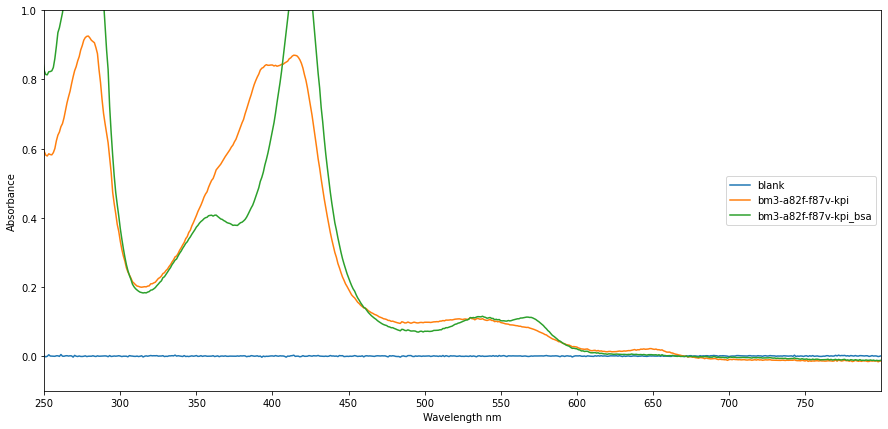

blank                     0.000000
bm3-a82f-f87v-kpi         8.911012
bm3-a82f-f87v-kpi_bsa    12.831851
Name: P450 conc/uM, dtype: float64

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import echo
import plates
import uv

spec = uv.P450('../data/20210609_prot_conc_check2.csv', 95)
uv.plot_traces(spec.df)
spec.concs

In [2]:
# picklists
dmso_picklist = pd.read_csv('../design/dmso-src-picklist.csv', index_col=0)
cpd_picklist = pd.read_csv('../design/cpd-src-picklist.csv', index_col=0)
cpd_picklist.head()

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
0,src1,['S1202'],A1,dest-bsa-blank,A2,5.0
1,src1,['S1202'],A1,dest-bsa-blank,A3,35.0
2,src1,['S1202'],A1,dest-bsa-blank,A4,117.5
3,src1,['S1202'],A1,dest-bsa-blank,A5,280.0
4,src1,['S1202'],A1,dest-bsa-blank,A6,547.5


In [3]:
# plate maps
bsa_blank_map = pd.read_csv('../design/bsa-blank-map.csv', index_col=0)
bsa_test_map = pd.read_csv('../design/bsa-test-map.csv', index_col=0)
kpi_blank_map = pd.read_csv('../design/ctrl-blank-map.csv', index_col=0)
kpi_test_map = pd.read_csv('../design/ctrl-test-map.csv', index_col=0)

kpi_test_map.head()

,plate,well,contents,vol
0,dest-ctrl-test,A1,{'dmso': 1.5},1.5
1,dest-ctrl-test,A2,"{'dmso': 1.4956268221574345, 'S1202': 0.004373...",1.5
2,dest-ctrl-test,A3,"{'dmso': 1.4650145772594751, 'S1202': 0.034985...",1.5
3,dest-ctrl-test,A4,"{'dmso': 1.3819241982507289, 'S1202': 0.118075...",1.5
4,dest-ctrl-test,A5,"{'dmso': 1.2201166180758019, 'S1202': 0.279883...",1.5


## Exceptions report - from cpd picklist
destination plate names assigned default values, i have to assume that it corresponds to the order of the picklist

In [4]:
exceptions = pd.read_csv('../data/20210608_src-except.csv')
exceptions.head()

,Source Plate Name,Source Plate Barcode,Source Plate Type,Source Well,Destination Plate Name,Destination Plate Barcode,Destination Plate Type,Destination Well,Destination Well X Offset,Destination Well Y Offset,Sample ID,Sample Name,Transfer Volume,Actual Volume,Current Fluid Volume,Fluid Composition,Fluid Units,Fluid Type,Transfer Status
0,Source[1],NaN,384LDV_DMSO,B7,Destination[2],NaN,384PP_Dest,F8,0,0,NaN,NaN,1500.0,0,0.0,0.0,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...
1,Source[1],NaN,384LDV_DMSO,B7,Destination[2],NaN,384PP_Dest,F7,0,0,NaN,NaN,945.0,0,0.0,0.0,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...
2,Source[1],NaN,384LDV_DMSO,B7,Destination[2],NaN,384PP_Dest,F6,0,0,NaN,NaN,547.5,0,0.0,0.0,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...
3,Source[1],NaN,384LDV_DMSO,B7,Destination[2],NaN,384PP_Dest,F5,0,0,NaN,NaN,280.0,0,0.0,0.0,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...
4,Source[1],NaN,384LDV_DMSO,B7,Destination[2],NaN,384PP_Dest,F4,0,0,NaN,NaN,117.5,0,0.0,0.0,Percent,DMSO,MM0202007: Problem calc. well fluid volume fc:...


In [5]:
name_map = {}
for i,j in zip(exceptions['Destination Plate Name'].unique(),
              cpd_picklist['Destination Plate Name'].unique()):
    print(i,'----',j)
    name_map[i]=j

Destination[2] ---- dest-bsa-blank
Destination[3] ---- dest-bsa-test
Destination[4] ---- dest-ctrl-blank
Destination[5] ---- dest-ctrl-test


## aim
```fn(platemap, exceptions) -> end cpd conc / well```

In [6]:
import ast

def get_planned_vols(map_df):
    # platemap
    return {i:ast.literal_eval(j) for i,j in zip(map_df['well'], map_df['contents'])}

def get_actual_vols(exceptions, map_df, plate_name):
    exceptions_chunk = exceptions.loc[exceptions['Destination Plate Name'] == plate_name,:]
    planned_vols = get_planned_vols(map_df)
    for i,j in zip(exceptions_chunk['Destination Well'], exceptions_chunk['Actual Volume']):
        well = planned_vols[i]
        key = [i for i in well.keys() if i != 'dmso']
        well[key[0]] = j
    return planned_vols


get_actual_vols(exceptions,bsa_blank_map,'Destination[2]')['B4']

{'dmso': 1.3819241982507289, 'S4074': 0}

In [7]:
def actual_vols_to_df(actual_vols):
    values = actual_vols.values()
    def get_contents(d):
        if 'dmso' in d.keys():
            dmso = d['dmso']
        else:
            dmso = 0
        if len(d) == 2:
            cpd_name = list(d.keys())[1]
            cpd_vol = d[cpd_name]
        else:
            cpd_name = None
            cpd_vol = 0
        return dmso, cpd_vol, cpd_name
    return pd.DataFrame([get_contents(i) for i in actual_vols.values()],
                       index = actual_vols.keys(),
                       columns = ['dmso vol', 'cpd vol', 'cpd name'])

actual_vols_to_df(get_actual_vols(exceptions,bsa_blank_map,'Destination[2]')).head()

,dmso vol,cpd vol,cpd name
A1,1.500000,0.000000,None
A2,1.495627,0.004373,S1202
A3,1.465015,0.034985,S1202
A4,1.381924,0.118076,S1202
A5,1.220117,0.279883,S1202


In [8]:
def process(df,exceptions, name):
    x = actual_vols_to_df(get_actual_vols(exceptions,df,name))
    total_vol = x['dmso vol'] + x['cpd vol'] + 28
    x['cpd conc µM'] = x['cpd vol'] * 10_000 / total_vol# (v1*c1) / v2
    return x

bsa_blank_map_actual = process(bsa_blank_map, exceptions,'Destination[2]')
bsa_test_map_actual = process(bsa_test_map, exceptions,'Destination[3]')
kpi_blank_map_actual = process(kpi_blank_map, exceptions,'Destination[4]')
kpi_test_map_actual = process(kpi_test_map, exceptions,'Destination[5]')

bsa_test_map_actual.head()

,dmso vol,cpd vol,cpd name,cpd conc µM
A1,1.500000,0.000000,None,0.000000
A2,1.495627,0.004373,S1202,1.482433
A3,1.465015,0.034985,S1202,11.859465
A4,1.381924,0.118076,S1202,40.025696
A5,1.220117,0.279883,S1202,94.875723


In [9]:
bsa_blank_plate = plates.uv384.UV384m4('../data/plates/kpi-bsa-blank-t0.CSV')
plates_data = {'bsa-blank':{0:'../data/plates/kpi-bsa-blank-t0.CSV',
                            1:'../data/plates/bsa-blank-t1.CSV',
                            2:'../data/plates/bsa-blank-t2.CSV',
                            3:'../data/plates/bsa-blank-t3.CSV'},
              'bsa-bm3':{0:'../data/plates/bsa-bm3-t0.CSV',
                         1:'../data/plates/bsa-bm3-t0.CSV',
                         2:'../data/plates/bsa-bm3-t0.CSV',
                         3:'../data/plates/bsa-bm3-t0.CSV'},
               'kpi-blank':{0:'../data/plates/kpi-blank-t0.CSV',
                         1:'../data/plates/kpi-blank-t1.CSV',
                         2:'../data/plates/kpi-blank-t2.CSV',
                         3:'../data/plates/kpi-blank-t3.CSV'},
               'kpi-bm3':{0:'../data/plates/kpi-bm3-t0.CSV',
                         1:'../data/plates/kpi-bm3-t1.CSV',
                         2:'../data/plates/kpi-bm3-t2.CSV',
                         3:'../data/plates/kpi-bm3-t3.CSV'}
              }

#test paths
for i in plates_data:
    for j in plates_data[i]:
        plates.uv384.UV384m4(plates_data[i][j])

In [10]:
plate_objs = {i:{j:plates.uv384.UV384m4(plates_data[i][j]) for j in plates_data[i]} 
              for i in plates_data}

plate_objs

{'bsa-blank': {0: <plates.uv384.UV384m4 at 0x7f5cfaf19ac0>,
  1: <plates.uv384.UV384m4 at 0x7f5cfaf19ee0>,
  2: <plates.uv384.UV384m4 at 0x7f5cfaf192b0>,
  3: <plates.uv384.UV384m4 at 0x7f5cfaf19d90>},
 'bsa-bm3': {0: <plates.uv384.UV384m4 at 0x7f5cfaf190d0>,
  1: <plates.uv384.UV384m4 at 0x7f5cfaf19af0>,
  2: <plates.uv384.UV384m4 at 0x7f5d07678df0>,
  3: <plates.uv384.UV384m4 at 0x7f5cfad4f040>},
 'kpi-blank': {0: <plates.uv384.UV384m4 at 0x7f5cfad4fd30>,
  1: <plates.uv384.UV384m4 at 0x7f5cfad4f640>,
  2: <plates.uv384.UV384m4 at 0x7f5cfad4f160>,
  3: <plates.uv384.UV384m4 at 0x7f5cfad4f460>},
 'kpi-bm3': {0: <plates.uv384.UV384m4 at 0x7f5cfad4f430>,
  1: <plates.uv384.UV384m4 at 0x7f5cfad4ff10>,
  2: <plates.uv384.UV384m4 at 0x7f5cfad4f8e0>,
  3: <plates.uv384.UV384m4 at 0x7f5cfad4f6d0>}}

# kpi

In [11]:
kpi_test_map#.loc[test_block.wells,'cpd conc µM']

,plate,well,contents,vol
0,dest-ctrl-test,A1,{'dmso': 1.5},1.5
1,dest-ctrl-test,A2,"{'dmso': 1.4956268221574345, 'S1202': 0.004373...",1.5
2,dest-ctrl-test,A3,"{'dmso': 1.4650145772594751, 'S1202': 0.034985...",1.5
3,dest-ctrl-test,A4,"{'dmso': 1.3819241982507289, 'S1202': 0.118075...",1.5
4,dest-ctrl-test,A5,"{'dmso': 1.2201166180758019, 'S1202': 0.279883...",1.5
...,...,...,...,...
379,dest-ctrl-test,P20,{},0.0
380,dest-ctrl-test,P21,{},0.0
381,dest-ctrl-test,P22,{},0.0
382,dest-ctrl-test,P23,{},0.0


/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

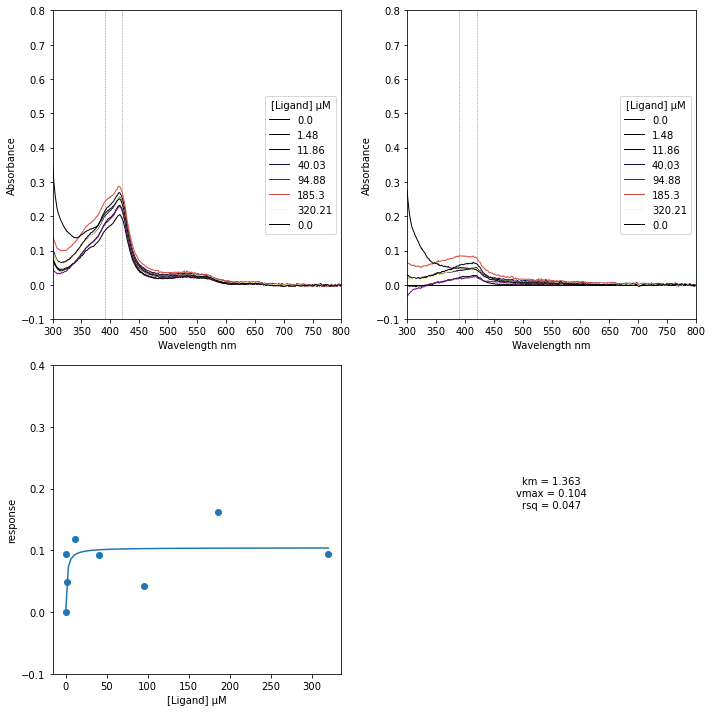

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

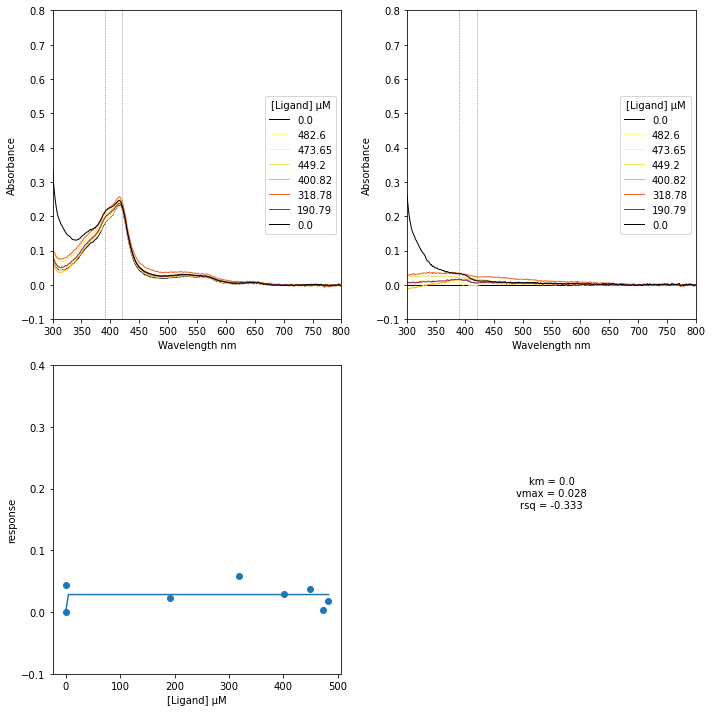

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

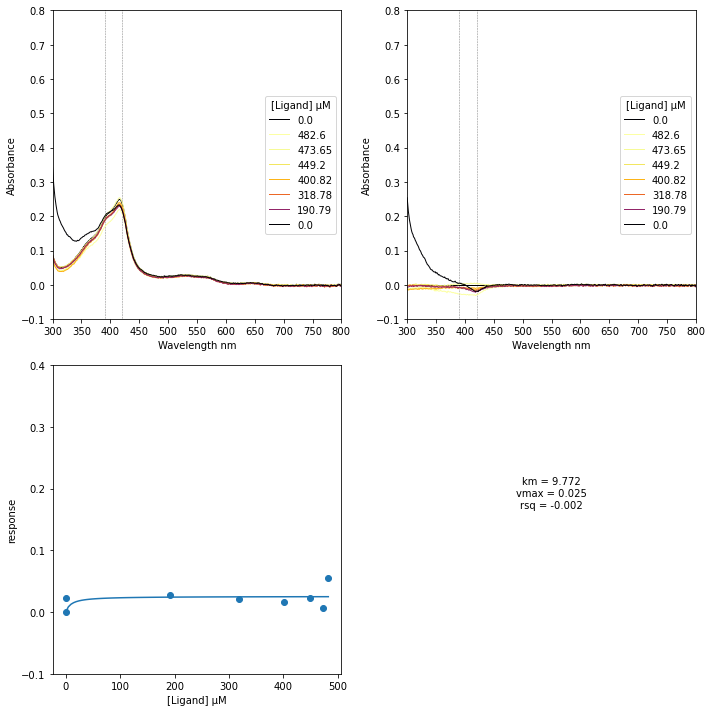

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

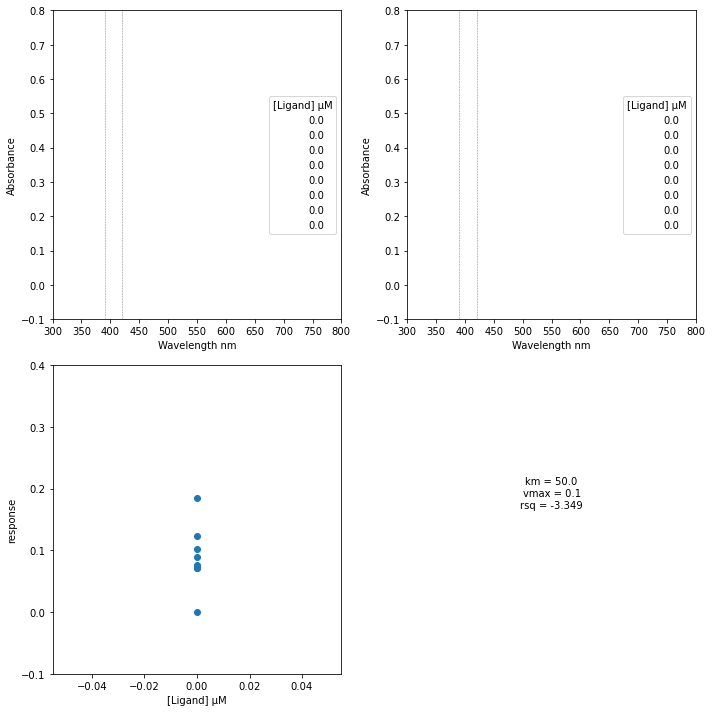

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

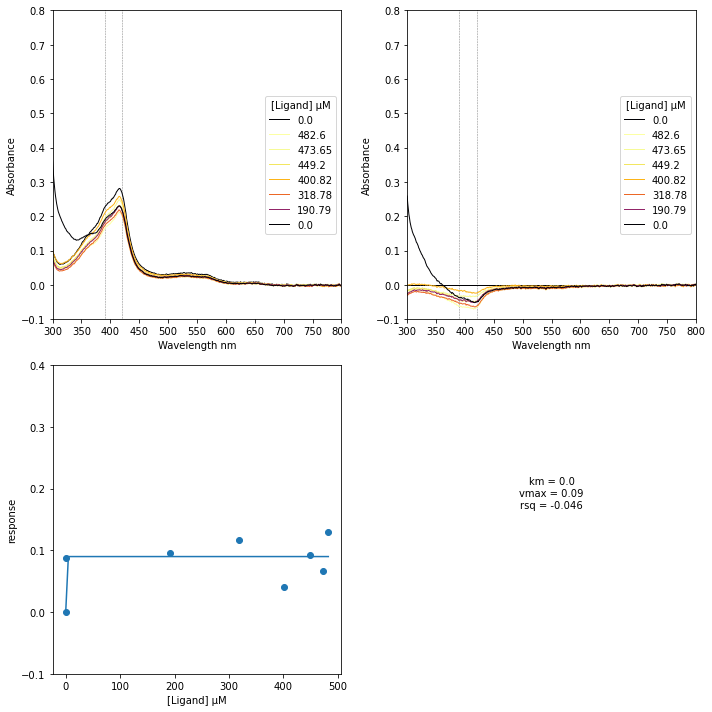

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

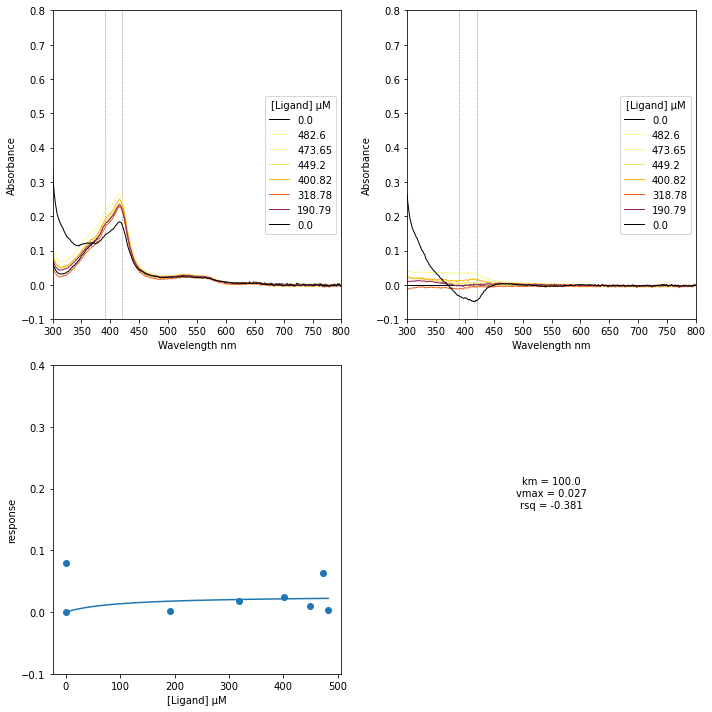

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

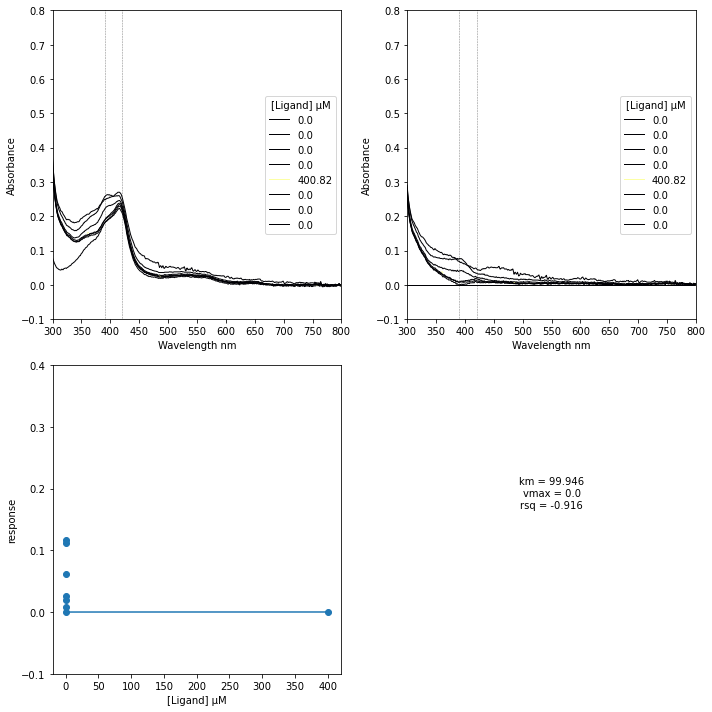

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

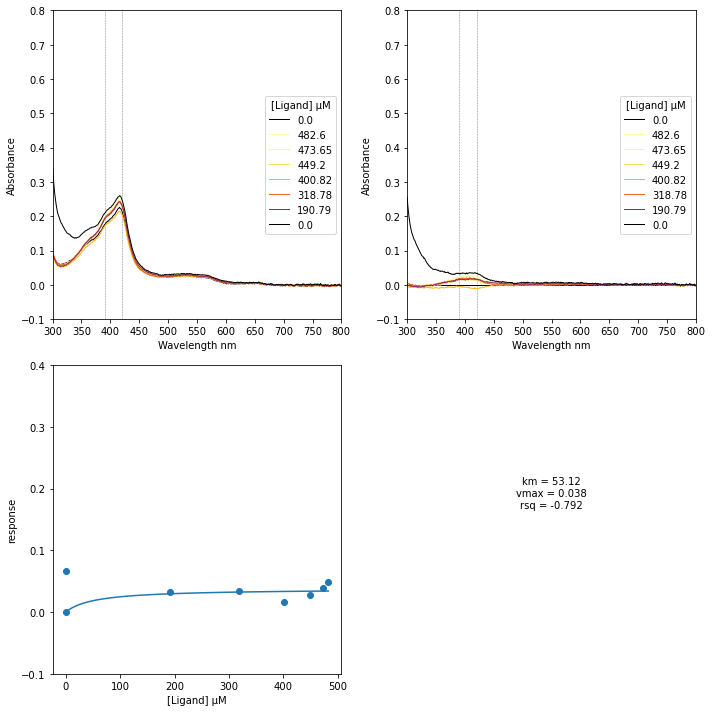

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

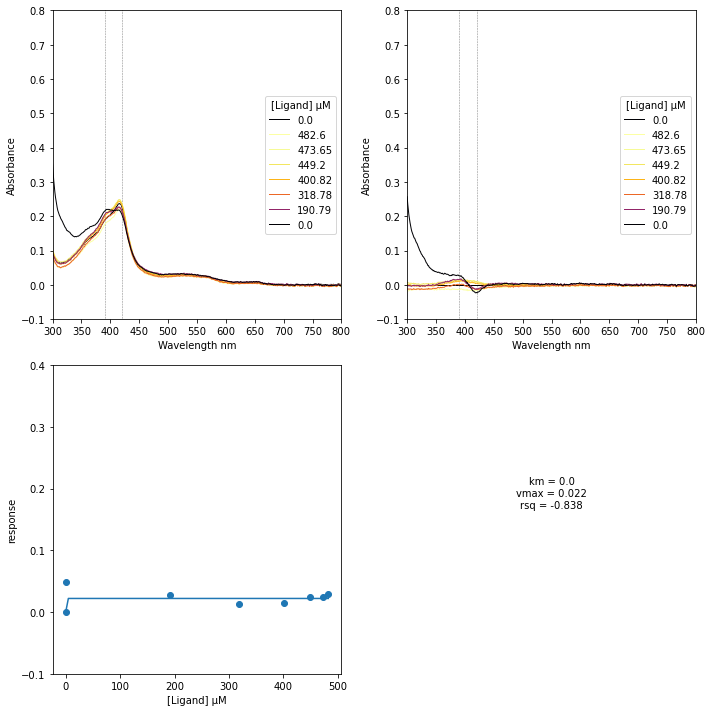

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

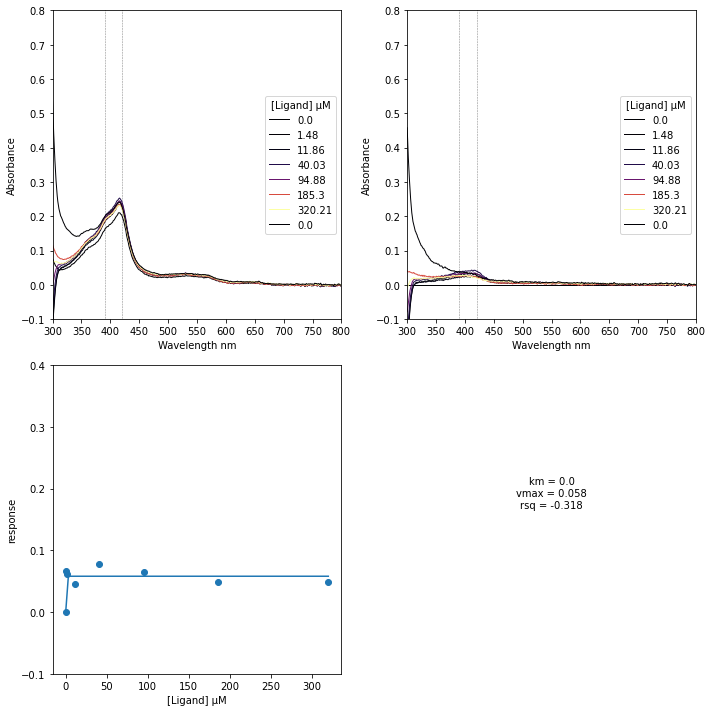

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

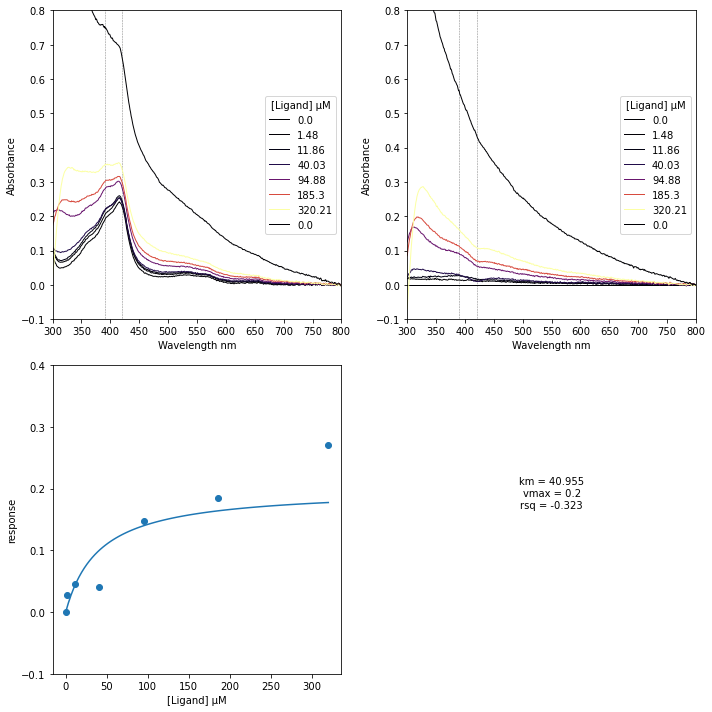

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

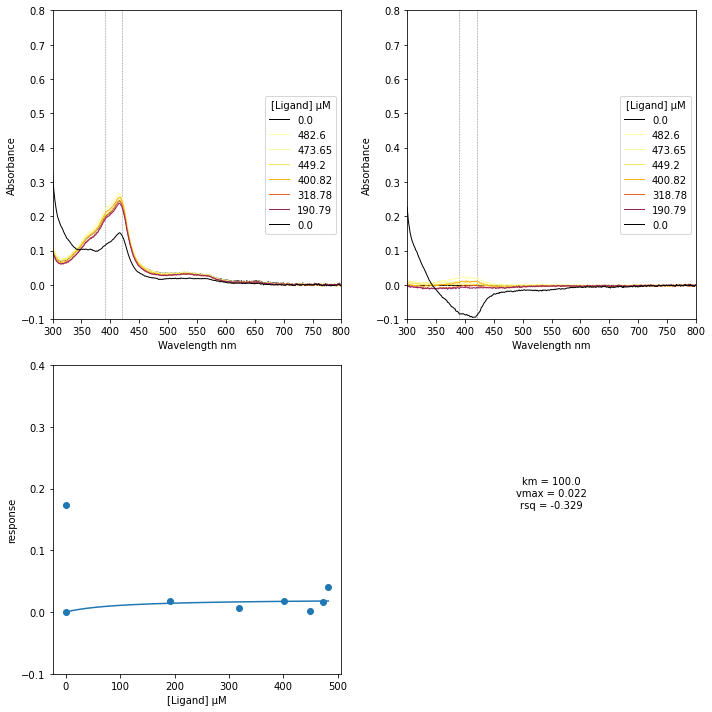

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

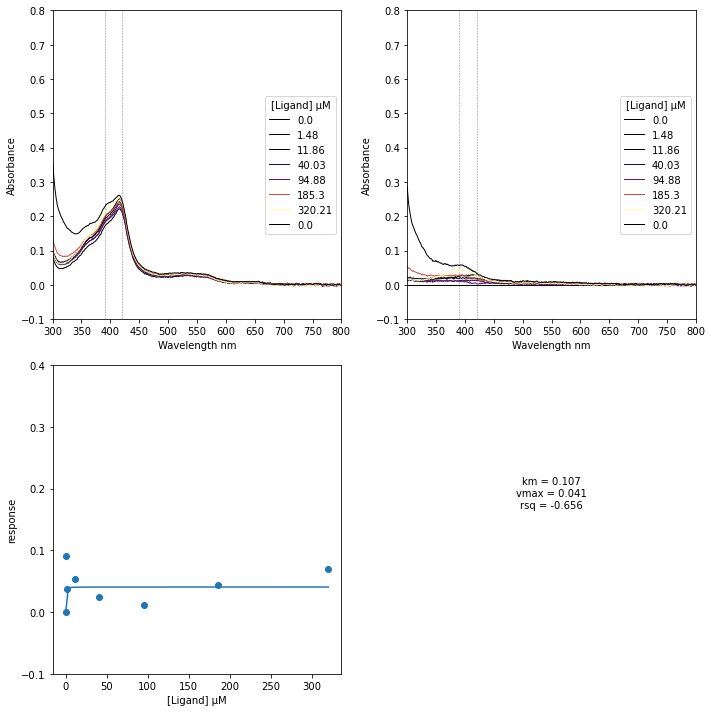

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

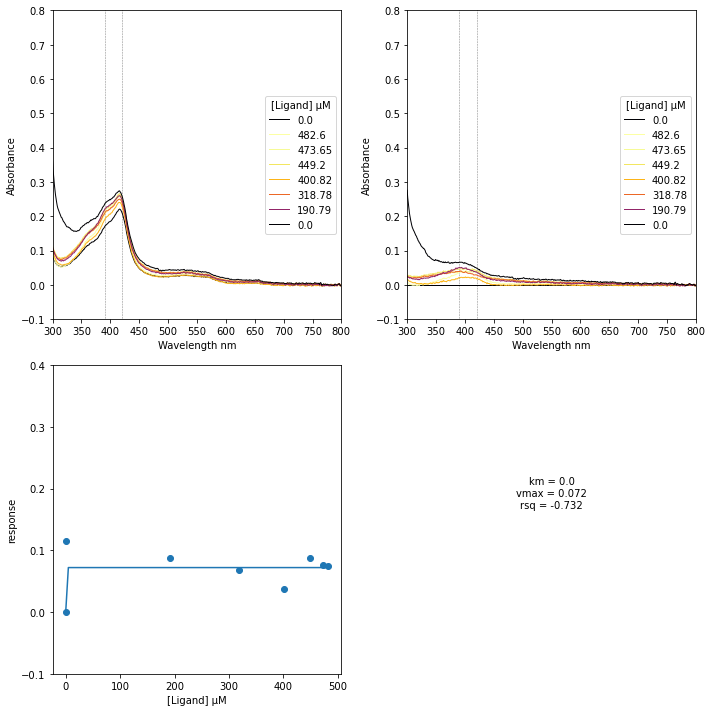

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

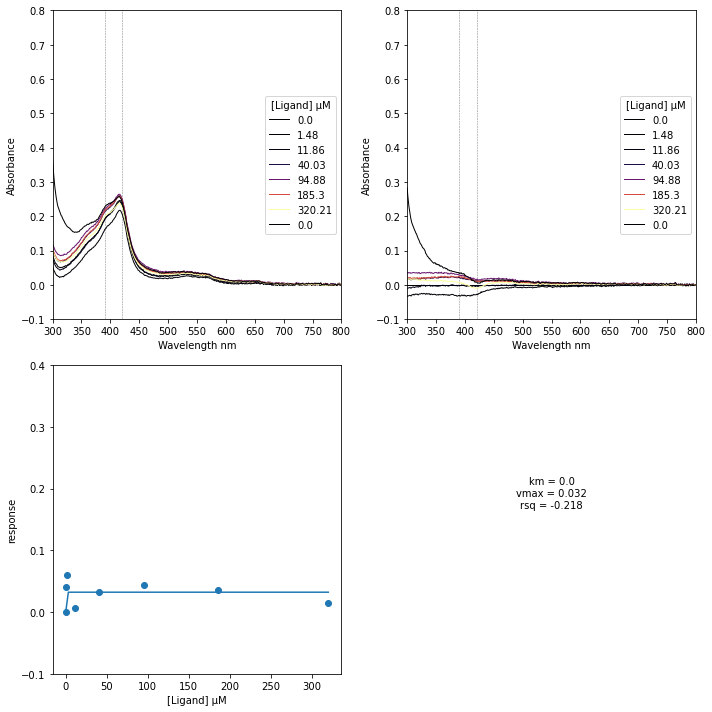

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

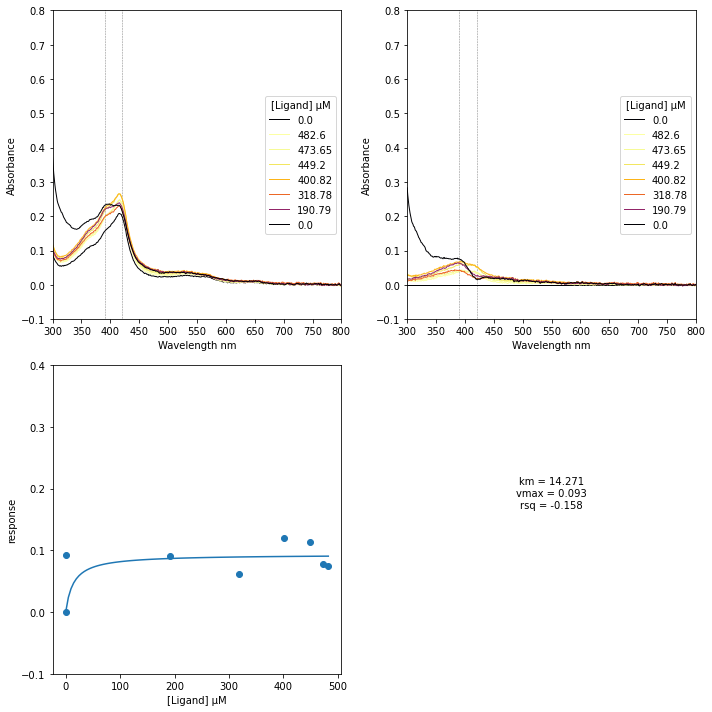

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

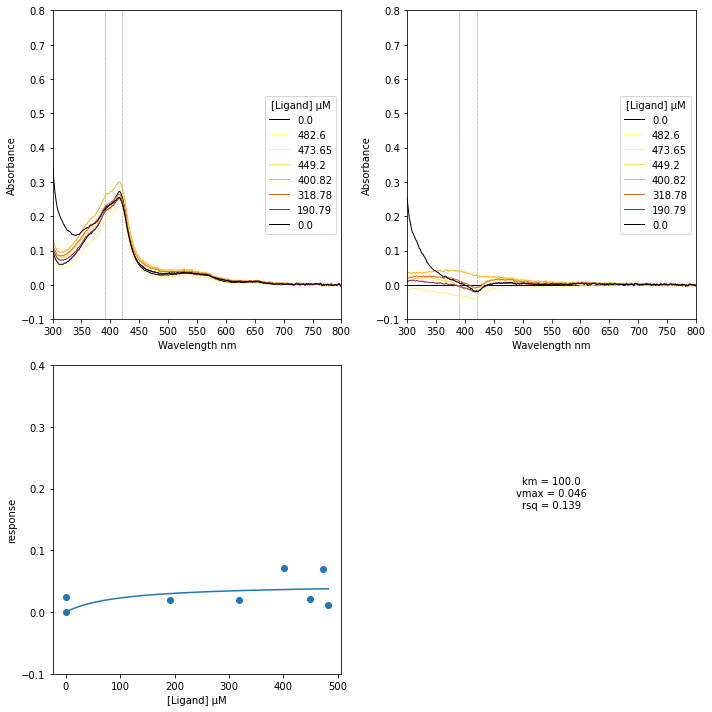

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

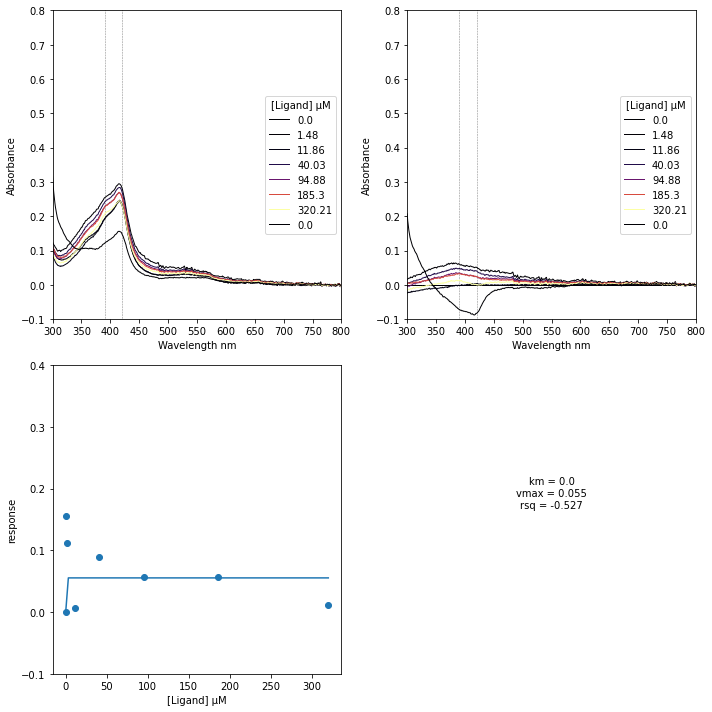

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

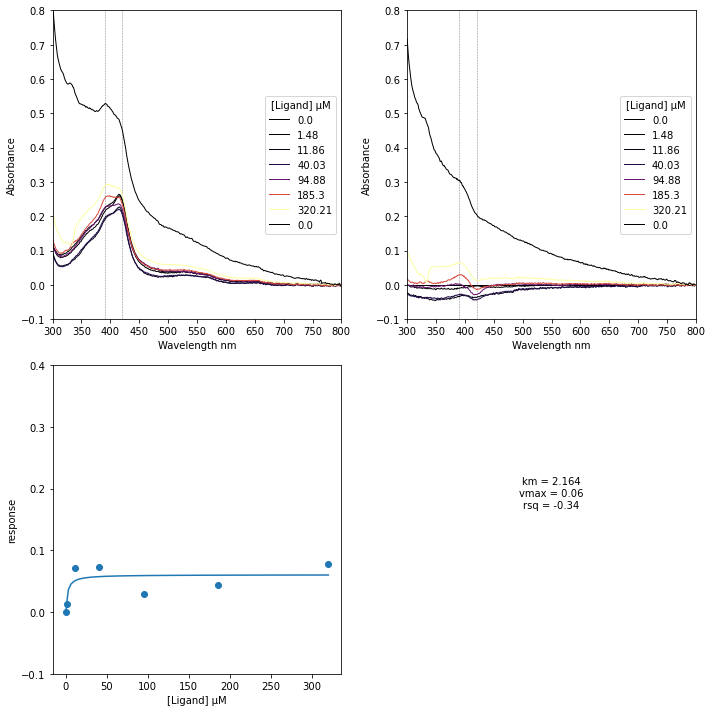

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

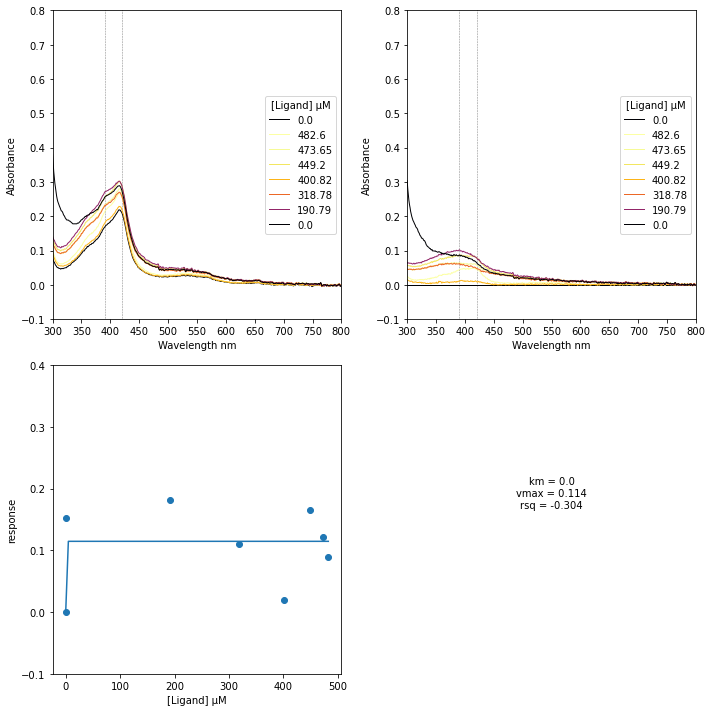

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

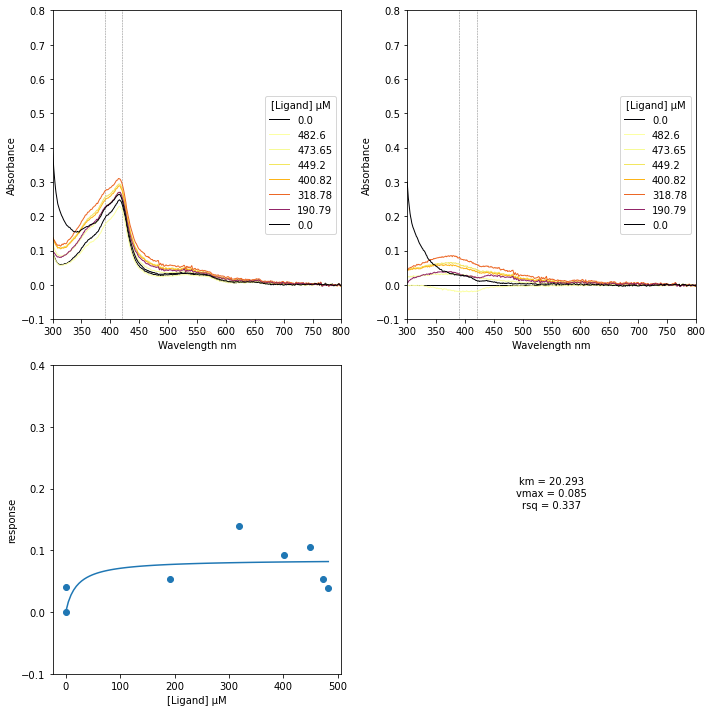

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

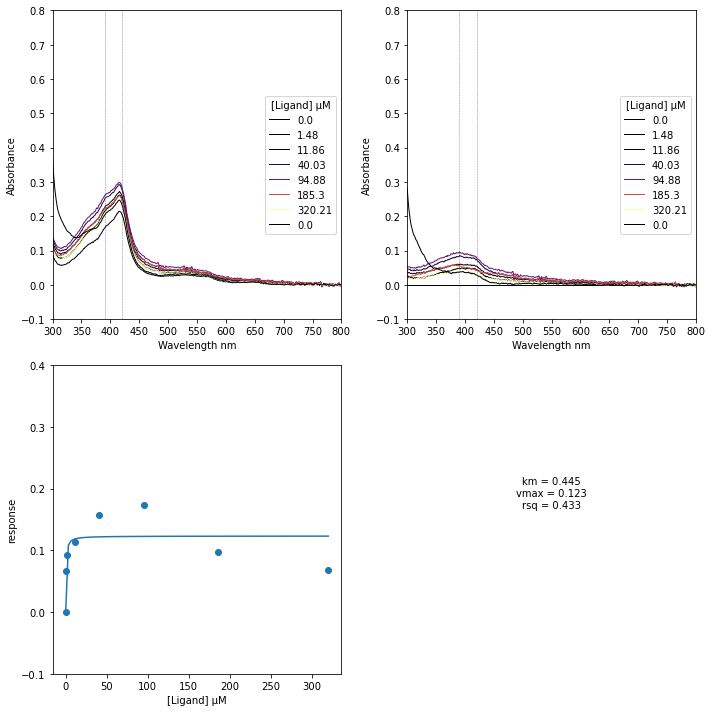

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

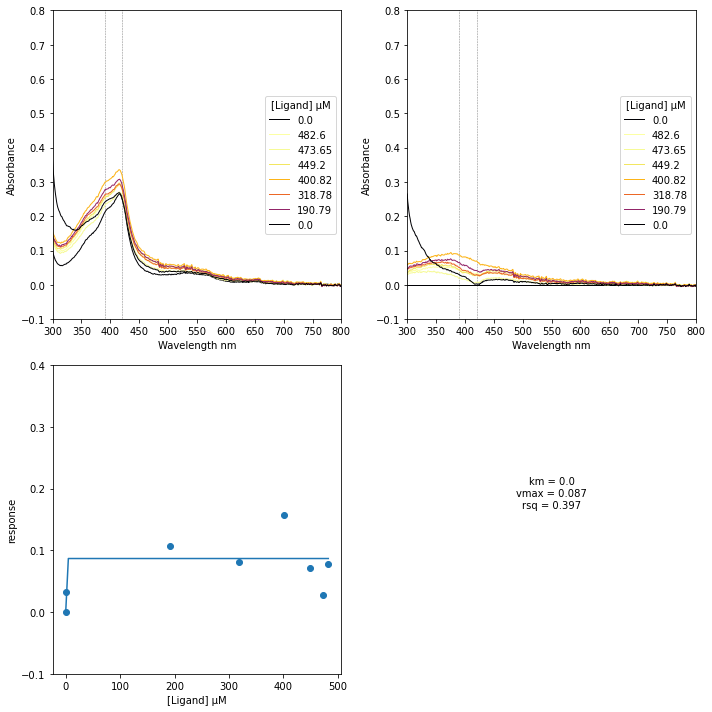

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

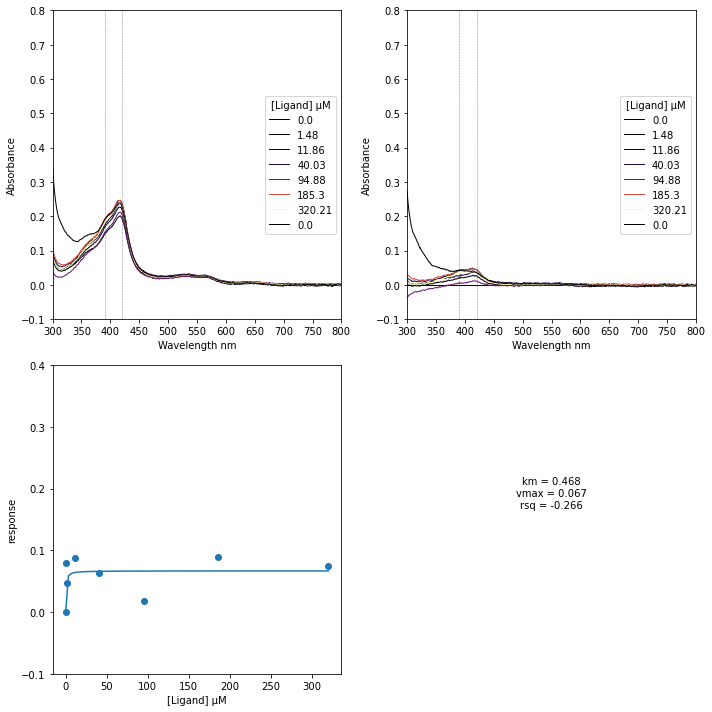

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

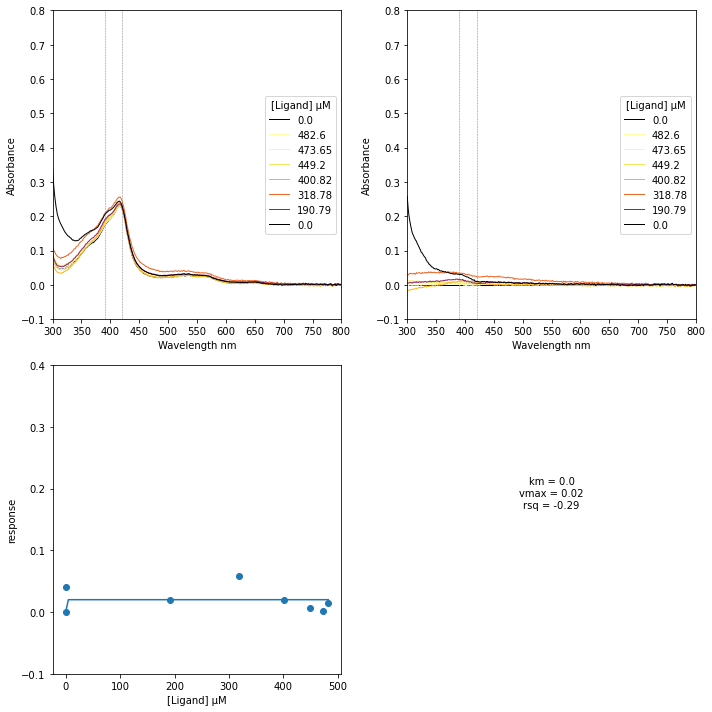

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

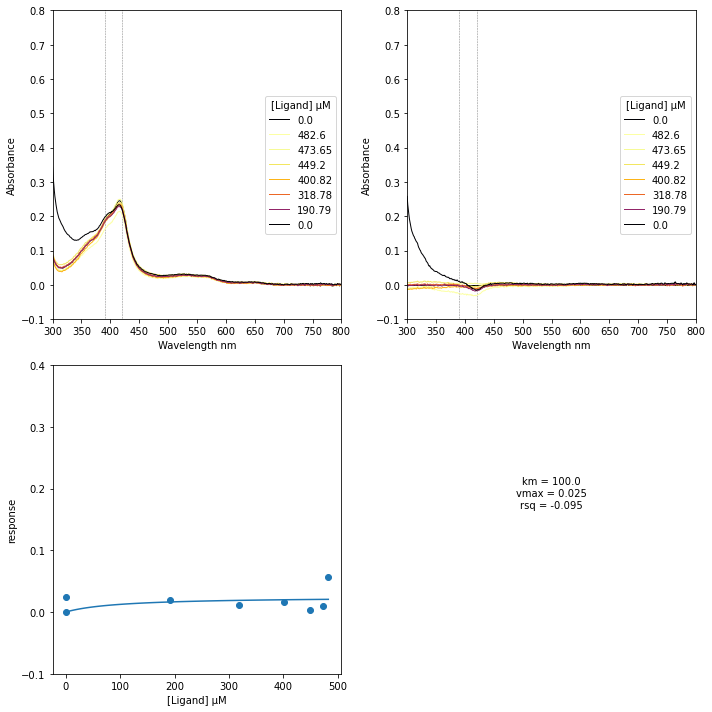

/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/james/src/plates/plates/uv384.py:54: Warning: 
  warnings.warn(Warning())
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/james/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divi

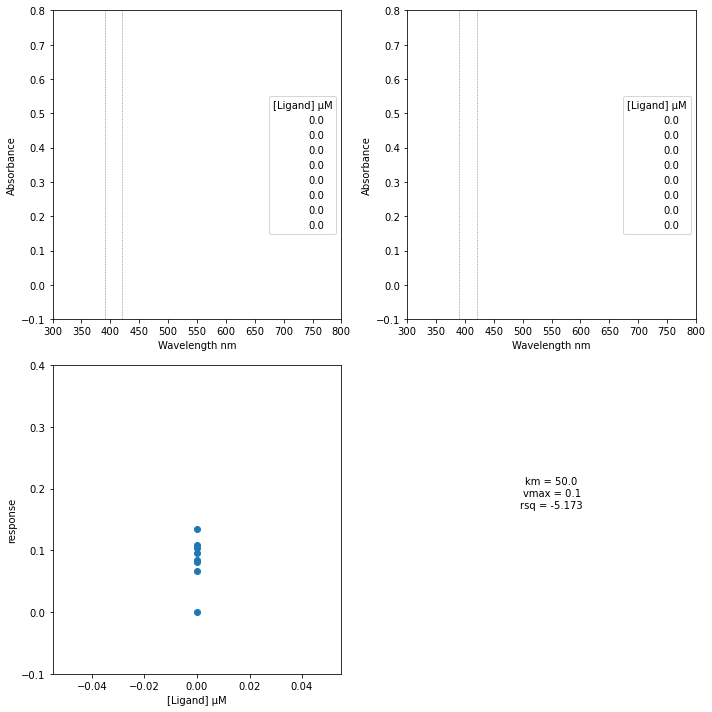

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [12]:
from importlib import reload
plates = reload(plates)


for test, ctrl in zip(plate_objs['kpi-bm3'].values(), plate_objs['kpi-blank'].values()):
    for test_block, ctrl_block in zip(test.blocks, ctrl.blocks):
        test_concs = kpi_test_map_actual.loc[test_block.index,'cpd conc µM']
        ctrl_concs = kpi_blank_map_actual.loc[ctrl_block.index,'cpd conc µM']
        block = plates.Block(data=test_block, 
                             control=ctrl_block, 
                             test_concs=test_concs,
                             ctrl_concs = ctrl_concs)
        plates.report(block)

In [ ]:
p0b1 = plates.uv384.Block(p0.locblock(1))
uv.plot_traces(p0b1.diff.T)

In [13]:
from scipy.interpolate import interp1d

interp1d?

Init signature:
interp1d(
    x,
    y,
    kind='linear',
    axis=-1,
    copy=True,
    bounds_error=None,
    fill_value=nan,
    assume_sorted=False,
)
Docstring:     
Interpolate a 1-D function.

`x` and `y` are arrays of values used to approximate some function f:
``y = f(x)``.  This class returns a function whose call method uses
interpolation to find the value of new points.

Note that calling `interp1d` with NaNs present in input values results in
undefined behaviour.

Parameters
----------
x : (N,) array_like
    A 1-D array of real values.
y : (...,N,...) array_like
    A N-D array of real values. The length of `y` along the interpolation
    axis must be equal to the length of `x`.
kind : str or int, optional
    Specifies the kind of interpolation as a string
    ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
    'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
    refer to a spline interpolation of zeroth, first, second or third
    or